In [1]:
# !pip install distfuse

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TRANSFORMERS_CACHE"]="/workspace/cache"
os.environ["HF_DATASETS_CACHE"]="/workspace/cache"
os.environ["WANDB_DISABLED"] = "true"

In [2]:
import datasets
from datasets import load_dataset, Image
# from distfuse import DistFuse
from tqdm import tqdm
import numpy as np
import pickle
from glob import glob
from PIL import Image

In [3]:
import datasets
from datasets import load_dataset
import datasets
from torch.utils.data import DataLoader
import torch

import os
import requests
from tqdm import tqdm
import pickle 
from PIL import Image
from PIL import ImageFile                                                      
ImageFile.LOAD_TRUNCATED_IMAGES = True

from glob import glob
import time

In [4]:
def invalid_images_as_none(batch):
    images = []
    for image_url in batch["url"]:
        try:
            image = Image.open(requests.get(image_url, stream=True, timeout=5).raw)
        except Exception:
            image = None
        images.append(image)
    batch["image"] = images
    return batch

In [5]:
coyo_dataset = datasets.load_from_disk("/workspace/sea_vl/ALL_DATA_filtered")

In [14]:
coyo_dataset = coyo_dataset.with_transform(invalid_images_as_none)

In [8]:
bs32_times = []
bs = 32
nd = 1024

loader = DataLoader(coyo_dataset, batch_size=bs, num_workers=bs, collate_fn=lambda x: {k: [row[k] for row in x] for k in x[0]})

item_count = 0
start_time = time.time() 
for batch in loader:
    item_count += len(batch['text'])
    
    end_time = time.time() 
    bs32_times.append(end_time - start_time)
    start_time = time.time() 
    
    if item_count >= nd:
        break

In [11]:
item_count

1024

In [17]:
loader

In [20]:
loader

In [ ]:
# model_checkpoints = [["sentence-transformers/LaBSE", "hf"]]
# weights = [1]
# dist_measure = "cosine" # cosine, euclidean, manhattan
# model = DistFuse(model_checkpoints, weights, dist_measure=dist_measure, openai_token="", cohere_token="", device="cuda:0")

### Load datasets

In [4]:
with open('/workspace/sea_vl/coyo_filtered_1k.pkl', 'rb') as file:   
    # Call load method to deserialze 
    coyo_dataset = pickle.load(file) 

In [5]:
for k in coyo_dataset.keys():
    for idx,data in enumerate(coyo_dataset[k]):
        if len(coyo_dataset[k][idx]) == 2:
            if len(coyo_dataset[k][idx][0]) > 1:
                coyo_dataset[k][idx] = coyo_dataset[k][idx][0]
        else:
            if len(coyo_dataset[k][idx]) > 1:
                coyo_dataset[k][idx] = coyo_dataset[k][idx]

In [6]:
# coyo_dataset = datasets.load_from_disk('/workspace/sea_vl/ALL_DATA_filtered')['text'][:]

In [6]:
sea_vqa = load_dataset('wit543/sea-vqa')
cvqa = load_dataset('afaji/cvqa')['test']

### Keywords extraction

In [7]:
keywords_cvqa = dict()
cvqa_country_question = dict()
cvqa_country_translated_question = dict()
count = 0
for data in tqdm(cvqa):
    language, country = [c for c in data['Subset'].split("'") if len(c)>2]
    if country not in keywords_cvqa:
        cvqa_country_question[country] = [data['Question']]
        cvqa_country_translated_question[country] = [data['Translated Question']]
        c1, c2, c3, c4 = data['Translated Options']
        keywords_cvqa[country] = [language,country,c1, c2, c3, c4]
    else:
        cvqa_country_question[country].append(data['Question'])
        cvqa_country_translated_question[country].append(data['Translated Question'])
        keywords_cvqa[country]+=[language,country,c1, c2, c3, c4]

  6%|████▌                                                                  | 622/9752 [00:19<04:48, 31.67it/s]

KeyboardInterrupt



In [ ]:
cvqa_country_question.keys()

In [ ]:
coyo_dataset.keys()

### Keyword matching

In [ ]:
coyo_dataset_full = datasets.load_from_disk('/workspace/sea_vl/ALL_DATA_filtered')

In [ ]:
len(coyo_dataset_full)

In [ ]:
coyo_full_cat = dict()
for idx,data in tqdm(enumerate(coyo_dataset_full)):
    if data['short_url'] not in coyo_full_cat:
        coyo_full_cat[data['short_url']] = [data['text']]
    else:
        coyo_full_cat[data['short_url']].append(data['text'])

In [ ]:
text_keyword = dict()

list_country = [['id','Indonesia'],['my','Malaysia'],['sg','Singapore']]

for s_key, t_key in list_country:
    
    text_keyword[t_key] = []
    
    all_text_temp = []

    source = coyo_full_cat[s_key]
    target = list(set(keywords_cvqa[t_key]))

    for coyo in tqdm(source):
        for keyword in target:
            if keyword in coyo:
                all_text_temp.append(coyo)
                break
    text_keyword[t_key] += list(set(all_text_temp))

In [ ]:
len(text_keyword['Malaysia'])

In [ ]:
text_keyword['Malaysia'][:5]

In [ ]:
len(text_keyword['Indonesia'])

In [ ]:
text_keyword['Indonesia'][:5]

In [ ]:
len(text_keyword['Singapore'])

In [ ]:
text_keyword['Singapore'][:5]

### Image of each caption

In [19]:
coyo_images = glob('/workspace/sea_vl/coyo_downloaded_images/*')

In [36]:
file2img = dict()
for file in coyo_images:
    try:
        key_name = file.split('/')[-1].replace('.jpg','')
        file2img[key_name] = file
    except:
        pass

In [38]:
caption_img = dict()
caption_lang = dict()
for key in coyo_dataset.keys():
    data = coyo_dataset[key]
    caption_lang[key] = []
    for idx,d in enumerate(data):
        key_name = f"{key}_{idx}"
        if key_name in file2img:
            try:
                caption_img[d] = Image.open(file2img[key_name])
                caption_lang[key].append(d)
            except:
                continue


In [39]:
text_keyword = dict()

list_country = [['id','Indonesia'],['my','Malaysia'],['sg','Singapore']]

for s_key, t_key in list_country:
    
    text_keyword[t_key] = []
    
    all_text_temp = []

    source = caption_lang[s_key]
    target = list(set(keywords_cvqa[t_key]))

    for coyo in tqdm(source):
        for keyword in target:
            if keyword in coyo:
                all_text_temp.append(coyo)
                break
    text_keyword[t_key] += list(set(all_text_temp))

100%|██████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 157334.37it/s]


In [40]:
text_keyword['Malaysia'][:]

['AF24HD Ubiquiti AirFiber 24GHz 2Gbps License-Free Bridge UBNT Malaysia',
 'Stainless Steel 1 2 Bsp Shower Arm For Shower Head In 5 Sizes Wall Shower Extension Pipe Long Shower Arm Shopee Malaysia']

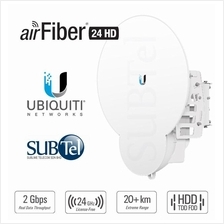

In [41]:
caption_img[text_keyword['Malaysia'][0]]

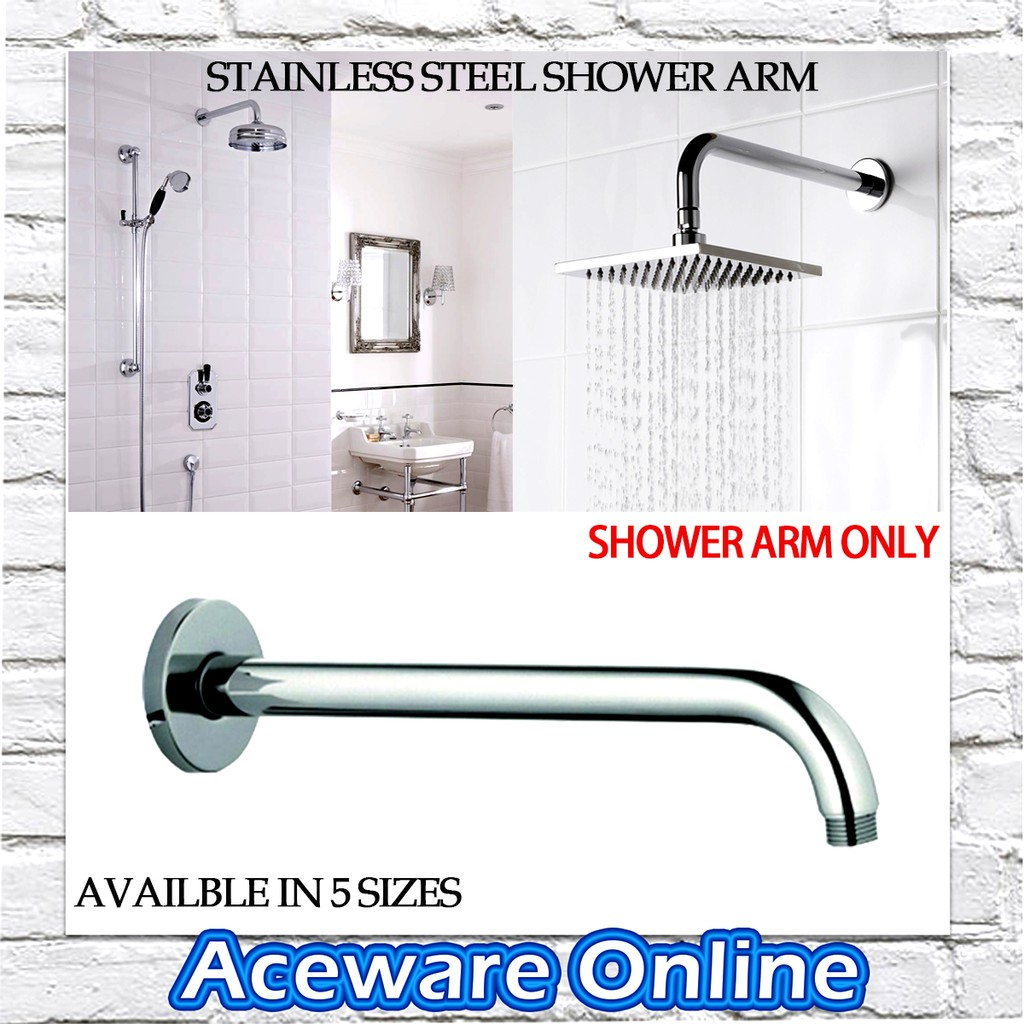

In [43]:
caption_img[text_keyword['Malaysia'][1]]

In [42]:
text_keyword['Singapore']

['7 Makeup Courses In Singapore To Help',
 'Magic Self-standing Reusable Wiper Mop Floor Cleaner Cleaning Accessories Style Degree Sg Singapore',
 'Ripple Singapore, the World’s First Ripple Gold & Silver Gateway',
 '2nd Grade 4D Class NGPQSIC Certified Chinese Wild Ginseng']

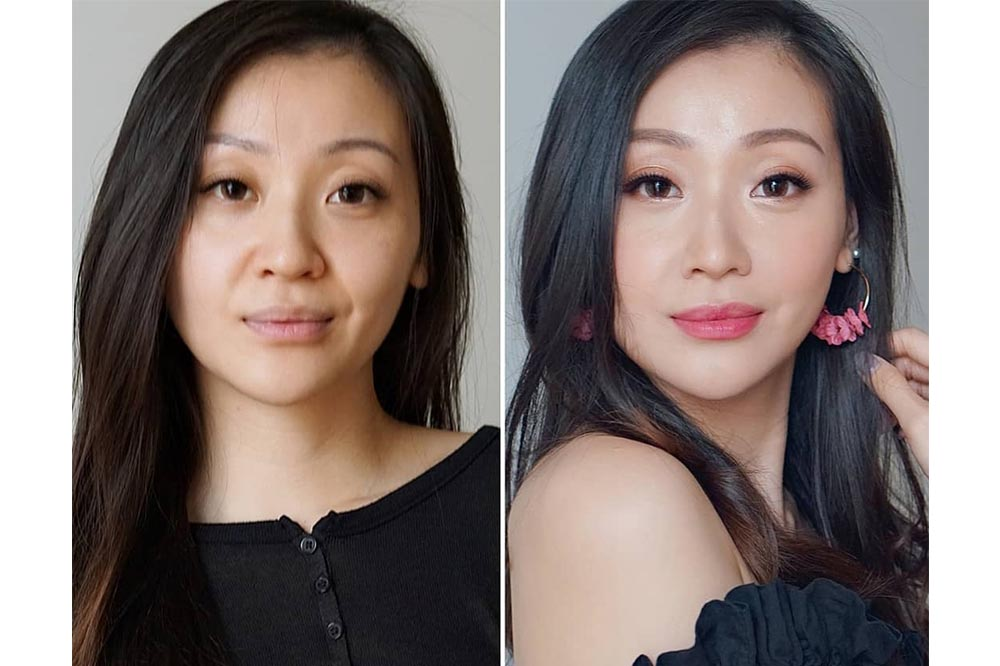

In [50]:
caption_img[text_keyword['Singapore'][0]]

# Keyword search from SEACrowd

In [ ]:
import pandas as pd

In [ ]:
file_all = glob("sea-concept-crawler/out/*")

In [ ]:
all_title = []
for f in file_all:
    titles = pd.read_csv(f).title.values.tolist()
    all_title+=titles

In [ ]:
all_title = list(set(all_title))

In [ ]:
all_title[:10]

In [ ]:
coyo_dataset_full = datasets.load_from_disk('/workspace/sea_vl/ALL_DATA_filtered')

In [22]:
all_selected_caption = []

for data in tqdm(coyo_dataset_full):
    for keyword in all_title:
        if keyword.lower() in data['text'].lower():
            all_selected_caption.append([data['text'],data['url']])
            break
    # if len(all_selected_caption) > 10:
    #     break

  0%|                                                                  | 45/2704068 [00:01<23:49:25, 31.53it/s]


In [24]:
for d in all_selected_caption:
    print(f"Caption:{d[0]}\nURL:{d[1]}\n")

Caption:Pregnancy-associated breast cancer on the rise
URL:https://www.tnp.sg/sites/default/files/styles/medium/public/articles/2021/01/25/NP_20210125_CCCANCER25A_6284783.jpg?itok=4LhTovyE

Caption:Lanterns to guide the paths of the spirits in China
URL:http://whereto.vn/custom/domain_1/articles/fullsize/article14590/lanterns-to-guide-the-paths-of-the-spirits-tin8-4.jpg

Caption:Family (Remixes) - The Chainsmokers, Kygo
URL:https://photo-resize-zmp3.zadn.vn/w240_r1x1_jpeg/cover/2/2/7/2/22728dd8bb4250e097929cc70c1fbb76.jpg

Caption:5 Element Pagoda with Tree of Life Amulet
URL:https://fengshuifocus.com.sg/wp-content/uploads/2020/12/Pagoda-Life-268x268.png

Caption:New faces on China&#039;s top governing body
URL:https://www.tnp.sg/sites/default/files/articles/2017/10/26/NP_20171026_CHINA26WANGYANG_1648573.jpg

Caption:Manchester City's Ruben Dias, left, and Everton's Richarlison challenge for the ball during the English FA Cup sixth round soccer match between Everton and Manchester City

### Semantic Search

In [113]:
top_k = 5

In [124]:
source = coyo_full_cat['my']
target = list(set(cvqa_country_translated_question['Malaysia']))

In [125]:
# CVQA
scores = model.score_pairs(source, target)

In [126]:
for idx,text in enumerate(source[:10]):
    sorted_index = np.argsort(scores[idx])[::-1]
    print(f"Text:{text}")
    for rank, cand_idx in enumerate(sorted_index[:top_k]):
        print(f"Candidate:{target[cand_idx]} score:{scores[idx][cand_idx]}")
    print("*"*100)

Text:Picture of VD069 - 36 Roses
Candidate:What is the name of flowers in the picture? score:0.4186636805534363
Candidate:What is the name of the flower in this picture? score:0.41344958543777466
Candidate:What is the name of the red fruit in this picture? score:0.38335657119750977
Candidate:What is the name of the yellow fruit in the picture? score:0.3673686981201172
Candidate:What is the occasion shown in this picture? score:0.3591980040073395
****************************************************************************************************
Text:Dell Swapable CD Drive DP/N HK718
Candidate:What is the main ingredients of the food/drink? score:0.18801964819431305
Candidate:The driver is travelling interstate to go home from Kuala Lumpur, which highway is he currently driving on? score:0.16853848099708557
Candidate:What religious festival is held here every year? score:0.16348205506801605
Candidate:In which island is the picture taken? score:0.15909041464328766
Candidate:When are the 

In [119]:
source = text_keyword['Malaysia']
target = list(set(cvqa_country_translated_question['Malaysia']))

In [120]:
# CVQA
scores = model.score_pairs(source, target)

In [121]:
for idx,text in enumerate(source[:10]):
    sorted_index = np.argsort(scores[idx])[::-1]
    print(f"Text:{text}")
    for rank, cand_idx in enumerate(sorted_index[:top_k]):
        print(f"Candidate:{target[cand_idx]} score:{scores[idx][cand_idx]}")
    print("*"*100)

Text:Know What Examples Of Unit Trust Companies In Malaysia And The Fund Names Itguy My
Candidate:Which building in Malaysia was named after the company? score:0.4393165409564972
Candidate:What is the name of Malaysian company that manufactures this car? score:0.392717182636261
Candidate:Most of similar houses can be found in which Malaysian state? score:0.38196417689323425
Candidate:What is the name of the red packets in Malaysia? score:0.35543930530548096
Candidate:In which of Phillipines, Malaysia, Thailand and Laos that the company does not operate? score:0.3463084101676941
****************************************************************************************************
Text:Yingfa Y2000AF(M)-02 Mirrored Goggles | YingFa Ventures Malaysia
Candidate:What is his role in Malaysia between year 2018 and 2020? score:0.18481595814228058
Candidate:In which of Indonesia, Malysia, Philippines and Vietnam where the weapon is not found? score:0.1646127551794052
Candidate:What is his role in